In [ ]:
# Rebinning with interpolation

In [113]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cnst

from groundcontrol.analysis.nt import noise_psd

In [272]:
rootdir = Path("C:/Users/ckutlu/Measurements/snrscan/")
datapath1 = rootdir/'SNRSCAN_5.981G_PICKED.nc'
datapath2 = rootdir/'SNRSCAN_5.921G_PICKED.nc'
datapath3 = rootdir/'SNRSCAN_5.855G_PICKED.nc'
datapath = datapath3
ds = xr.open_dataset(datapath).transpose()
ds

<xarray.Dataset>
Dimensions:            (delta: 666, ppump: 94)
Coordinates:
  * delta              (delta) float64 -1.808 -1.799 -1.764 ... 2.081 2.188
  * ppump              (ppump) float64 0.0 0.2 0.4 0.6 ... 18.0 18.2 18.4 18.6
Data variables:
    snr_on             (ppump, delta) float64 ...
    snr_on_std         (ppump, delta) float64 ...
    snr_off            (ppump, delta) float64 ...
    snr_off_std        (ppump, delta) float64 ...
    snr_on_noise       (ppump, delta) float64 ...
    snr_on_noise_std   (ppump, delta) float64 ...
    snr_off_noise      (ppump, delta) float64 ...
    snr_off_noise_std  (ppump, delta) float64 ...
    gain               (ppump, delta) float64 ...
    fpump              (ppump, delta) float64 ...
    fcenter            (ppump, delta) float64 ...
    fr                 (ppump, delta) float64 ...
    bw0                (ppump, delta) float64 ...
Attributes:
    nuarray:              [-10000.  -5000.   5000.  10000.]
    nuarray_description:  SNR measurement frequency points relative to the fp...
    description:          The SNR measurements are done at several nu values....

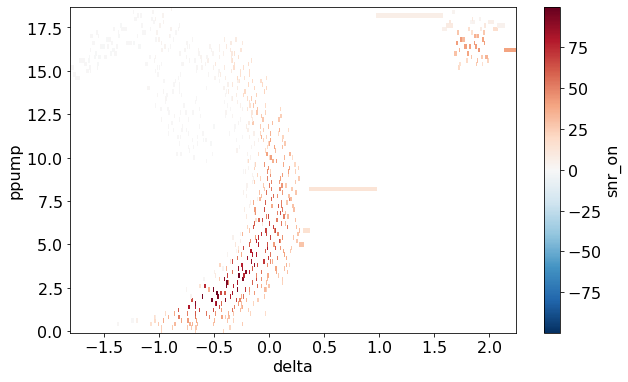

In [273]:
ds.snr_on.plot.pcolormesh()

In [274]:
deltas = np.arange(-2, 2.1, 0.1)
delta = ds.coords['delta']

deltaedges = np.arange(-2.05, 2.15, 0.1)
deltacenters = deltaedges[:-1]+0.05
binidx = np.digitize(delta, delta_bins)
ds.coords['delta_alt'] = ('delta', deltas[binidx-2])
dsnew = ds.groupby_bins('delta', deltaedges, labels=deltacenters, restore_coord_dims=True).mean().transpose().rename({'delta_bins': 'delta'})

C:\Users\ckutlu\Anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


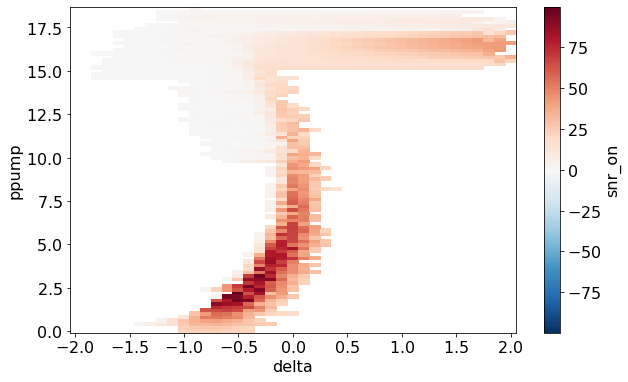

In [275]:
interpds = dsnew.interpolate_na(dim='delta')
interpds.snr_on.plot.pcolormesh()

In [276]:
tndf = pd.read_csv(rootdir/"nt_baseline_last_measurement.csv", names=['f','gain', 'gain_std', 'tn', 'tn_std'], comment='#')
tnds = tndf.set_index('f').to_xarray()
tnds

<xarray.Dataset>
Dimensions:   (f: 110)
Coordinates:
  * f         (f) float64 5e+09 5.01e+09 5.02e+09 ... 6.08e+09 6.09e+09 6.1e+09
Data variables:
    gain      (f) float64 2.687e+06 2.648e+06 2.66e+06 ... 2.805e+06 2.839e+06
    gain_std  (f) float64 1.408e+04 1.769e+04 1.147e+04 ... 8.559e+03 4.282e+03
    tn        (f) float64 8.622 8.826 8.885 8.841 ... 11.34 11.12 10.96 10.81
    tn_std    (f) float64 0.04837 0.06306 0.04095 ... 0.009255 0.03532 0.01724

C:\Users\ckutlu\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:3077: RuntimeWarning: invalid value encountered in less
  op(left_distances, right_distances) | (right_indexer == -1),


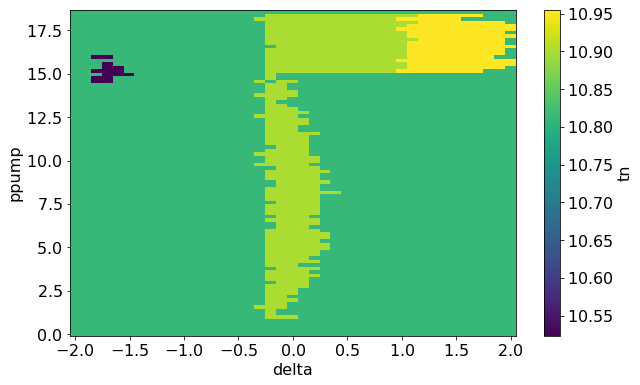

In [277]:
tndssel = tnds.sel(f=interpds.fcenter, method='nearest')
tndssel.tn.plot()

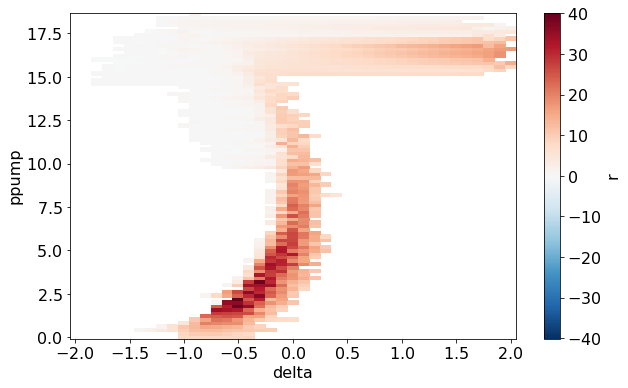

In [278]:
mds = interpds
mds = mds.assign({'r': mds.snr_on/mds.snr_off})
mds.r.plot.pcolormesh()

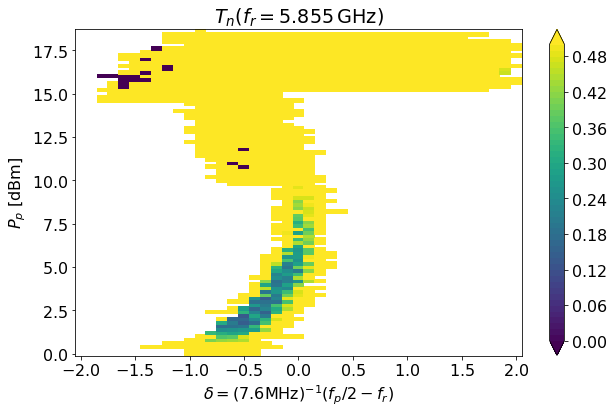

In [279]:
T_fridge = 0.04  # K
tnf = noise_psd(T_fridge, mds.fcenter)/cnst.Boltzmann

tn_all = (1/mds.r)*(tnf + tndssel.tn) - tnf
tn_all.plot.pcolormesh(vmin=0, vmax=0.5, levels=51)
bw0 = ds.bw0.mean().values
plt.xlabel(f'$\delta = ({bw0/2e6:.1f} \mathrm{{MHz}})^{{-1}}(f_p/2 - f_r)$')
plt.ylabel('$P_p$ [dBm]')
plt.title(f"$T_n(f_r={ds.fr.mean().values/1e9:.3f}\,\mathrm{{GHz}})$")

plt.savefig(f"{datapath!s}.png", dpi=300)

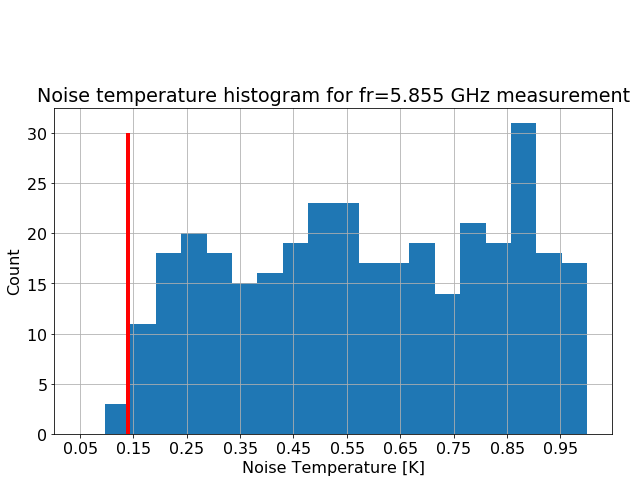

In [280]:
# lot of analysis artifacts
fig, ax = plt.subplots()
fr = ds.fr.mean().values
tn_all.plot.hist(ax=ax, bins=20, range=(0.05, 1), xticks=np.arange(0.05, 1.05, 0.1))
tq = noise_psd(0.04, fr)/cnst.Boltzmann
ax.vlines(tq, ymin=0, ymax=30, color='red', linewidth=4)
ax.annotate(f'$T_Q^{{\mathrm{{ADDED}}}}$={tq:.3f} K', (tq, 40+1), ha='center')
ax.set_xlabel("Noise Temperature [K]")
ax.set_ylabel("Count")
ax.set_title(f"Noise temperature histogram for fr={fr/1e9:.3f} GHz measurement")
ax.grid()